In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.optim as optim
from torch import nn
from d2l import torch as d2l

In [2]:
# 特征工程
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
data0 = train_df.copy()
data1 = test_df.copy()

In [4]:
cate_cols = []
num_cols =[]
dtypes = data0.dtypes

for col, dtype in dtypes.items():
    if dtype == 'object':
        cate_cols.append(col)
    else:
        num_cols.append(col)
             
print(cate_cols)
print(num_cols)

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [5]:
data0.drop(labels='Ticket',axis=1,inplace=True) #把Ticket列删除
data0.drop(labels='Cabin',axis=1,inplace=True) #Cabin
data0.drop(labels='Name',axis=1,inplace=True) #Name

In [6]:
data0.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

In [7]:
# 计算年龄的均值
data0['Age'].mean()

29.69911764705882

In [8]:
# 空缺值处理
data0['Age'].fillna(29.5,inplace=True)

In [9]:
data0.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
dtype: int64

In [10]:
# Embarked,Sex属性列由字符列改为数值列
f_names = ['Sex','Embarked']
for x in f_names:
    label = preprocessing.LabelEncoder()
    data0[x] = label.fit_transform(data0[x])

In [11]:
data0.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [12]:
train_y = data0['Survived']
train_x = data0.drop('Survived',axis=1)

In [13]:
data1.drop(labels='Name',axis=1,inplace=True) #Name
data1.drop(labels='Cabin',axis=1,inplace=True) #Cabin
data1.drop(labels='Ticket',axis=1,inplace=True) #Ticket

In [14]:
print(train_x.shape)
print(train_y.shape)
print(data1.shape)

(891, 8)
(891,)
(418, 8)


In [15]:
# Sex,Embarked属性列由字符列改为数值列
f_names = ['Sex','Embarked']
for x in f_names:
    label = preprocessing.LabelEncoder()
    data1[x] = label.fit_transform(data1[x])

In [16]:
data1.isnull().sum()

PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64

In [17]:
data1['Age'].mean()

30.272590361445783

In [18]:
# 空缺值处理
data1['Age'].fillna(30,inplace=True)

In [19]:
data1['Fare'].fillna(0,inplace=True)

In [20]:
data = pd.concat([train_x,data1],axis=0,ignore_index=True)

In [21]:
n_train = data0.shape[0]
train_features = data[:n_train]
test_features = data[n_train:]
train_labels = train_y
print(train_features.shape)
print(test_features.shape)

(891, 8)
(418, 8)


In [22]:
# 划分数据集
train_data, test_data, train_label, test_label = train_test_split(train_features, train_labels,test_size = 0.2)

In [23]:
print(train_data.shape)
print(test_data.shape)

(712, 8)
(179, 8)


In [24]:
train_labels1 = np.expm1(train_labels)
train_features1 = torch.tensor(data[:n_train].values,dtype = torch.float32)
test_features1 = torch.tensor(data[n_train:].values,dtype = torch.float32)
train_labels1 = torch.tensor(train_labels1.values.reshape(-1,1),dtype=torch.float32)

In [25]:
loss = nn.MSELoss()
in_features = train_features1.shape[1]
print(in_features)

8


In [26]:
def get_net():
    net = nn.Sequential(
                        nn.Linear(in_features,8),
                        nn.ReLU(),nn.Linear(8,4),
                        nn.ReLU(),nn.Linear(4,2),
                        nn.ReLU(),nn.Linear(2,1))
    return net

In [27]:
def rmse(net,features,labels):
    clam = torch.clamp(net(features),1,float('inf'))
    rmse = torch.sqrt(loss(clam,labels))
    
    return rmse.item()

In [28]:
def train(net,train_features,train_labels,test_features,test_labels,
               num_epochs,learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    
    optimizer = optim.Adam(net.parameters(), lr=lr, eps=1e-08,weight_decay=weight_decay)
    
    for epoch in range(num_epochs):
        for X,y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            optimizer.step()
            
        train_ls.append(rmse(net,train_features, train_labels))
        
        if test_labels is not None:
            test_ls.append(rmse(net,test_features, test_labels))
    
    return train_ls, test_ls

In [29]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):

        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i==0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train rmse {float(train_ls[-1]):f}, '
              f'valid rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

In [34]:
k, num_epochs, lr, weight_decay, batch_size = 5, 500,0.001, 0.001, 32

# train_l, vali_l = k_fold(k,train_features1,train_labels1,num_epochs,lr,
#                         weight_decay,batch_size)

In [31]:
sub_data = pd.read_csv('gender_submission.csv')

In [32]:
def train_and_pred(train_features, test_feature, train_labels, sub_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train rmse {float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_feature).detach().numpy()
    preds = pd.Series(preds.reshape(1,-1)[0])
    # 将其重新格式化以导出到Kaggle
    sub_data['Survived'] = pd.Series(preds.values.reshape(1, -1)[0])
    submission = sub_data
    submission.to_csv('v3/submission.csv', index=False)
    return preds

train rmse 0.880406


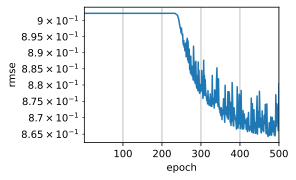

In [35]:
preds = train_and_pred(train_features1,test_features1,train_labels1,sub_data,
                      num_epochs,lr,weight_decay,batch_size)

# sub_data['Survived'] = preds
# submission = sub_data
# submission.to_csv('v3/submission.csv',index=False)

In [37]:
sub_data['Survived'].mean()

0.23211241

In [38]:
sub_data['Survived'] = [1 if x > 0.23211241 else 0 for x in sub_data['Survived'] ]

In [40]:
sub_data.to_csv('v3/submission2.csv',index=False)